In [1]:
from CO2_Dataset_Preparation import *
from ML_Model_Master import *
from datetime import datetime
import pickle

position_number = 4
feature_columns = ['Pic_CO2','ANEM_X','ANEM_Y','ANEM_Z','wd','ws']
downsample_sec = 600
periods_to_lag = [3]
tower = 'Picarro'
train_percent = 0.7

activation = 'relu'
neurons = [128]
dropout_rate = [0.2,0.3]
learn_rate = [0.001]#,1e-4,1e-5]
decay = [1e-5]#,1e-6]
batch_size = [10,20]#,50,100]
epochs = [10]#,50,100]

#file_name = 'testlog'#'ML_Models/PN{}_DS{}_Lag{}_Neur{}_DR{}'.format(position_number,downsample_sec,periods_to_lag[0],neurons[0],dropout_rate[0])
#logfile=open('{}.txt'.format(file_name),'w')

logfile = None

Using TensorFlow backend.


In [17]:
#Preprocess data and save as pkl

# data = Dataset('../CO2_Data_Final',position_number,logfile = logfile)
# data._preprocess()

# ml_data = ML_Data(feature_columns,downsample_sec,periods_to_lag[0],tower,train_percent)
# ml_data._ML_Process(data)

# with open('ML_dataset_{}DS.pkl'.format(downsample_sec), 'wb') as file:
#     pickle.dump(ml_data, file)

Downsampling by mean at 600 seconds
Downsampling by mean at 600 seconds
Adding Wind Direction as 'wd'
Adding Wind Speed as 'ws'


In [3]:
#Load Preprocessed Dataset
with open('ML_dataset_600DS.pkl', 'rb') as file:
    ml_data = pickle.load(file)

In [4]:
try:
    print_log_flush("-------------------------BUILD AND TRAIN MODELS-------------------------",logfile)

    tot_train = len(periods_to_lag)*len(neurons)*len(dropout_rate)*len(learn_rate)*len(decay)*len(batch_size)*len(epochs)-1

    models = []
    i = 0


    for neur in neurons:
        for dr in dropout_rate:
            for lr in learn_rate:
                for dec in decay:
                    for bs in batch_size:
                        for ep in epochs:
                            print_log_flush(f"---Training Model: {i} of {tot_train}---",logfile)
                            ml_model = ML_Model_Builder(activation,neur,dr,lr,dec,bs,ep)
                            ml_model._train_model(ml_data)
                            delattr(ml_model,'logfile')
                            models.append(ml_model)
                            print(models)
                            i+=1

    error_name  = 'rmse'   

    error_vals = []
    for m in models:
        error_vals.append(m.history.history[error_name][-1])
    best_idx = error_vals.index(min(error_vals))

    print_log_flush("-------------------------RESULTS-------------------------",logfile)

    print_log_flush(f"Best score for '{error_name}' was {min(error_vals)} in model {best_idx}",logfile)

    print_log_flush(f"Downsampling Seconds: {models[best_idx].downsample_sec}\n\
    Lag Periods: {models[best_idx].periods_to_lag}\n\
    Activation: {models[best_idx].activation}\n\
    Neurons: {models[best_idx].neurons}\n\
    Learning Rate: {models[best_idx].learn_rate}\n\
    Decay: {models[best_idx].decay}\n\
    Epochs: {models[best_idx].epochs}",logfile)

    print_log_flush("-------------------------SAVE FILE-------------------------",logfile)

    with open('{}.pkl'.format(file_name), 'wb') as models_file:
         pickle.dump(models, models_file)

    print_log_flush(f"Saved list of models to {file_name}",logfile)
    print_log_flush(f"Models built with optimizer: {models[best_idx].opt_string}",logfile)

    now = datetime.now()
    dt_string = now.strftime("%Y/%m/%d %H:%M:%S")
    print_log_flush('*******************************END TIME = {}************************************'.format(dt_string),logfile)
except Exception as e:
    print_log_flush('Error occurred ' + str(e),logfile)
if logfile is not None:
    logfile.close()

-------------------------BUILD AND TRAIN MODELS-------------------------
---Training Model: 0 of 3---
Downsampling = 600
Lag Periods = 3        
activation=relu
neurons=128
dropout_rate=0.2        
learn_rate=0.001
decay=1e-05
batch size=10
epochs=10
Train on 903 samples, validate on 388 samples
Epoch 1/10
903/903 [==============================] - 3s 3ms/step - loss: 0.1027 - rmse: 0.2775 - val_loss: 0.0838 - val_rmse: 0.2539
Epoch 2/10
903/903 [==============================] - 2s 2ms/step - loss: 0.0695 - rmse: 0.2175 - val_loss: 0.0605 - val_rmse: 0.1838
Epoch 3/10
903/903 [==============================] - 2s 2ms/step - loss: 0.0532 - rmse: 0.1807 - val_loss: 0.0373 - val_rmse: 0.1327
Epoch 4/10
903/903 [==============================] - 1s 1ms/step - loss: 0.0436 - rmse: 0.1492 - val_loss: 0.0278 - val_rmse: 0.1115
Epoch 5/10
903/903 [==============================] - 1s 1ms/step - loss: 0.0406 - rmse: 0.1383 - val_loss: 0.0253 - val_rmse: 0.1106
Epoch 6/10
903/903 [=============

Fitting data from X_test


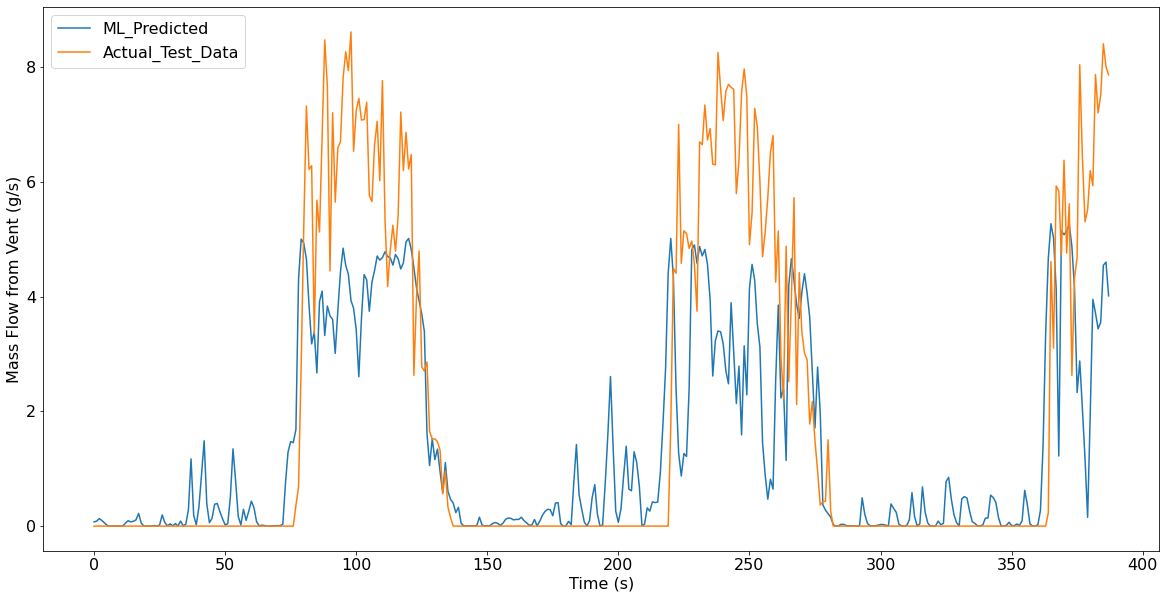

In [5]:
import matplotlib.pyplot as plt

i=best_idx

models[i]._fit_data(ml_data)

#Return to original data shape and scale
X_test_original_shape = ml_data.X_test.reshape(ml_data.orig_X_test_shape) #reshape from 3d time
y_test_original_shape = ml_data.y_test.reshape(ml_data.orig_y_test_shape)#reshape from 3d time 

merged_tests = np.concatenate((X_test_original_shape,y_test_original_shape[:,None]),axis=1) #concat X and y
unscaled_test = pd.DataFrame(ml_data.min_max_scalar.inverse_transform(merged_tests)).iloc[:,-1] #unscale using declared scalar

y_fit_original_shape = ml_data.y_fit.reshape(ml_data.orig_y_test_shape)
merged_tests = np.concatenate((X_test_original_shape,y_fit_original_shape[:,None]),axis=1)
unscaled_fit = pd.DataFrame(ml_data.min_max_scalar.inverse_transform(merged_tests)).iloc[:,-1]

#Put into pandas df
comparison = pd.concat([unscaled_test,unscaled_fit],axis=1)
comparison.columns = ['test','fit']

#PLOT PREDICTED VS OBSERVED
fig, ax = plt.subplots(figsize = (20,10))
# ax.plot(ml_data.y_fit,label='ML_Fit_to_Test')
# ax.plot(ml_data.y_test,label='Actual_Test_Data')

roll = 1

ax.plot(comparison['fit'].rolling(roll).mean(),label='ML_Predicted')
ax.plot(comparison['test'].rolling(roll).mean(),label='Actual_Test_Data')

ax.set_xlabel('Time (s)',fontsize=16)
ax.set_ylabel('Mass Flow from Vent (g/s)',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)


ax.legend(fontsize=16)
plt.show()